In [ ]:
from google.colab import drive
drive.mount('/content/drive')
print("Google Drive mounted. Please ensure your dataset_path variable is correctly set and proceed to the next step to re-evaluate the path and process the dataset.")

Mounted at /content/drive
Google Drive mounted. Please ensure your dataset_path variable is correctly set and proceed to the next step to re-evaluate the path and process the dataset.


In [ ]:
import os


dataset_path = "/content/drive/MyDrive/data"

# Verify the path is set
if not dataset_path:
    raise ValueError("Please define the 'dataset_path' variable with the location of your image dataset.")

print(f"le chemin du dataset: {dataset_path}")

# If it's a directory, list its contents to inspect structure
if os.path.isdir(dataset_path):
    print("\nCe que contient le dataset:")
    for item in os.listdir(dataset_path):
        print(f"- {item}")

else:
    print("\nPath does not appear to be a valid directory or supported archive.")

le chemin du dataset: /content/drive/MyDrive/data

Ce que contient le dataset:
- test
- train
- val


Chargement des images depuis : /content/drive/MyDrive/data
Found 574 files belonging to 2 classes.

Nombre de classes détectées : 2
Classes : ['Cancer', 'Negative']


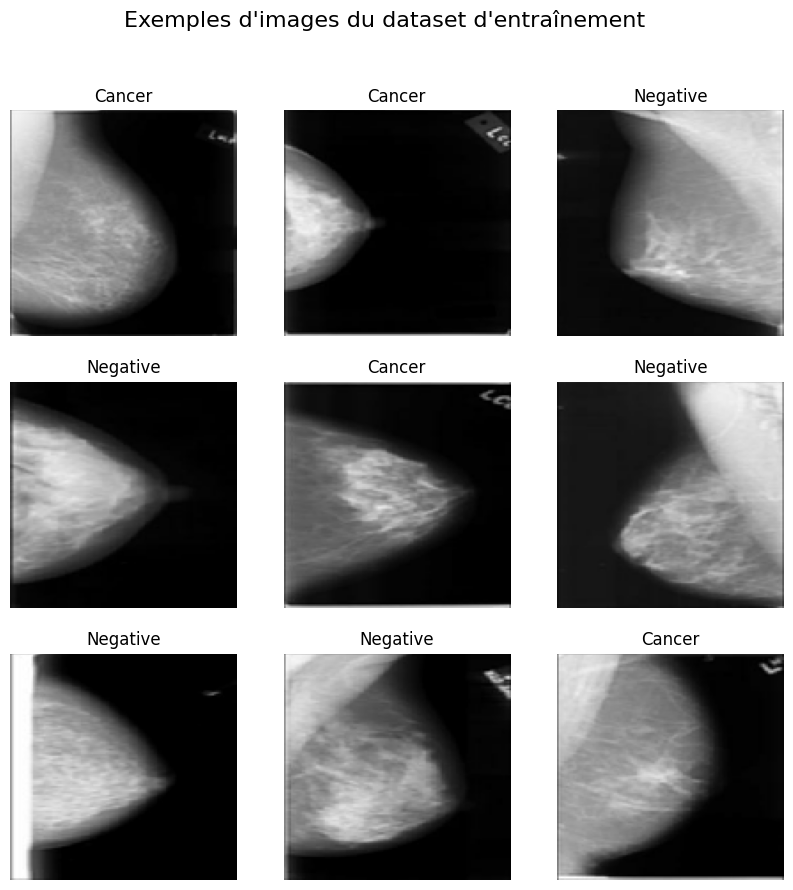

Les images d'exemple ont été chargées et affichées avec succès.


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

# Vérifier que le chemin du dataset a bien été défini dans une cellule précédente
if 'dataset_path' not in locals() or dataset_path is None:
    raise ValueError(
        "dataset_path n'est pas défini. Veuillez exécuter les cellules précédentes pour définir le chemin du dataset."
    )

print(f"Chargement des images depuis : {dataset_path}")

# Définition des paramètres des images
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32

# On suppose que la structure du dataset est :
# dataset_path/train/nom_de_classe/image.jpg
# Nous allons charger un petit échantillon des images d'entraînement pour les visualiser
train_dir = os.path.join(dataset_path, 'train')

# Vérifier si le dossier 'train' existe
if not os.path.isdir(train_dir):
    print(
        f"Attention : le dossier d'entraînement n'a pas été trouvé dans {train_dir}. "
        f"Chargement direct depuis {dataset_path}."
    )
    data_to_load = dataset_path
else:
    data_to_load = train_dir

# Charger les images à partir du dossier
# Le paramètre seed permet d'avoir toujours le même ordre (reproductibilité)
train_ds = tf.keras.utils.image_dataset_from_directory(
    data_to_load,
    labels='inferred',          # Les labels sont déduits automatiquement à partir des noms des dossiers
    label_mode='int',           # Les labels sont des entiers (0, 1, 2, ...)
    image_size=(IMG_HEIGHT, IMG_WIDTH),  # Redimensionnement des images
    interpolation='nearest',
    batch_size=BATCH_SIZE,
    shuffle=True,               # Mélanger les images
    seed=123
)

# Récupérer les noms des classes détectées
class_names = train_ds.class_names
print(f"\nNombre de classes détectées : {len(class_names)}")
print(f"Classes : {class_names}")

# Visualisation de quelques images du dataset
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):  # Prendre un seul batch
    for i in range(min(9, BATCH_SIZE)):  # Afficher jusqu'à 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

plt.suptitle("Exemples d'images du dataset d'entraînement", fontsize=16)
plt.show()

print("Les images d'exemple ont été chargées et affichées avec succès.")

In [ ]:
import tensorflow as tf
import os

# Re-define dataset_path to ensure it's accessible in this cell
dataset_path = "/content/drive/MyDrive/data"

# 1. Définir les chemins complets vers les répertoires 'train', 'val' et 'test'
train_dir = os.path.join(dataset_path, 'train')
val_dir = os.path.join(dataset_path, 'val')
test_dir = os.path.join(dataset_path, 'test')

print(f"Répertoire d'entraînement : {train_dir}")
print(f"Répertoire de validation : {val_dir}")
print(f"Répertoire de test : {test_dir}")

# --- Verification des chemins et de la structure des données ---
def verify_directory_for_flow_from_directory(directory_path, split_name):
    if not os.path.isdir(directory_path):
        raise FileNotFoundError(
            f"Erreur: Le répertoire '{directory_path}' pour le jeu de données de {split_name} n'existe pas. "
            f"Veuillez vérifier le chemin ou la structure de votre dataset sur Google Drive."
        )

    # Check if the directory contains any subdirectories (which are expected to be classes)
    subdirs = [d for d in os.listdir(directory_path) if os.path.isdir(os.path.join(directory_path, d))]
    if not subdirs:
        raise ValueError(
            f"Erreur: Le répertoire '{directory_path}' pour le jeu de données de {split_name} est vide ou ne contient pas de sous-dossiers de classes. "
            f"Pour utiliser `flow_from_directory`, la structure attendue est: {directory_path}/NOM_DE_CLASSE/image.jpg."
            f"Veuillez organiser votre dataset en conséquence."
        )
    print(f"Le répertoire '{directory_path}' pour le jeu de données de {split_name} contient des sous-dossiers de classes. Classes trouvées: {subdirs}")

try:
    verify_directory_for_flow_from_directory(train_dir, 'entraînement')
    verify_directory_for_flow_from_directory(val_dir, 'validation')
    verify_directory_for_flow_from_directory(test_dir, 'test')
except (FileNotFoundError, ValueError) as e:
    print(f"\nImpossible de créer les générateurs de données en raison d'une erreur de structure de répertoire.\n")
    print(e)
    print("\nVeuillez vous assurer que votre dataset est organisé comme suit :")
    print(f"  {dataset_path}/train/ClasseA/image1.jpg")
    print(f"  {dataset_path}/train/ClasseB/image2.jpg")
    print("  ...")
    print("Et de même pour les dossiers 'val' et 'test'.")
    raise # Re-raise the exception to stop execution until the user fixes the data structure

# --- Fin de la vérification ---

# Définition des paramètres des images (déjà définis précédemment, mais pour clarté)
IMG_WIDTH = 128
IMG_HEIGHT = 128
BATCH_SIZE = 32

# 2. Créer une instance de ImageDataGenerator pour l'entraînement avec augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,                 # Normalisation des pixels (0-1)
    rotation_range=20,              # Rotation aléatoire de 20 degrés
    width_shift_range=0.2,          # Décalage horizontal aléatoire
    height_shift_range=0.2,         # Décalage vertical aléatoire
    shear_range=0.2,                # Cisaillement aléatoire
    zoom_range=0.2,                 # Zoom aléatoire
    horizontal_flip=True,           # Retournement horizontal aléatoire
    vertical_flip=True,             # Retournement vertical aléatoire
    fill_mode='nearest'             # Stratégie de remplissage pour les pixels manquants
)

# 3. Créer une instance de ImageDataGenerator pour la validation et le test (seulement normalisation)
val_test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# 4. Utiliser la méthode .flow_from_directory() pour créer les générateurs de données
# Pour l'entraînement
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',            # 'binary' car 2 classes (Cancer, Negative)
    color_mode='rgb',               # Images couleur
    shuffle=True,
    seed=123
)

# Pour la validation
validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,                  # Pas de mélange pour la validation et le test
    seed=123
)

# Pour le test
test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    seed=123
)

# 5. Récupérer les noms de classes
class_names_from_generator = list(train_generator.class_indices.keys())
print(f"\nNoms de classes détectés par le générateur : {class_names_from_generator}")
print(f"Nombre de classes : {len(class_names_from_generator)}")

print("Générateurs de données créés avec succès pour l'entraînement, la validation et le test.")


Répertoire d'entraînement : /content/drive/MyDrive/data/train
Répertoire de validation : /content/drive/MyDrive/data/val
Répertoire de test : /content/drive/MyDrive/data/test
Le répertoire '/content/drive/MyDrive/data/train' pour le jeu de données de entraînement contient des sous-dossiers de classes. Classes trouvées: ['Negative', 'Cancer']
Le répertoire '/content/drive/MyDrive/data/val' pour le jeu de données de validation contient des sous-dossiers de classes. Classes trouvées: ['Negative', 'Cancer']
Le répertoire '/content/drive/MyDrive/data/test' pour le jeu de données de test contient des sous-dossiers de classes. Classes trouvées: ['Negative', 'Cancer']
Found 574 images belonging to 2 classes.
Found 122 images belonging to 2 classes.
Found 124 images belonging to 2 classes.

Noms de classes détectés par le générateur : ['Cancer', 'Negative']
Nombre de classes : 2
Générateurs de données créés avec succès pour l'entraînement, la validation et le test.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

print("Designing CNN model with Transfer Learning...")

# 1. Load a pre-trained base model (MobileNetV2) without its top classification layer
# Reuse IMG_HEIGHT, IMG_WIDTH from previous cells
base_model = DenseNet121(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')

# 2. Freeze the layers of the pre-trained base model
base_model.trainable = False

# 3. Create a new classification head on top of the frozen base model
x = base_model.output
x = GlobalAveragePooling2D()(x) # Global average pooling layer
x = Dense(128, activation='relu')(x) # A dense layer before the output layer
output_layer = Dense(1, activation='sigmoid')(x) # Final dense layer for binary classification

# 4. Combine the base model and the classification head into a complete Model
model = Model(inputs=base_model.input, outputs=output_layer)

# 5. Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

print("Model designed and compiled successfully!")
model.summary()

Designing CNN model with Transfer Learning...
29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Model designed and compiled successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 134, 134,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 32, 32,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 32, 32,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 32, 32,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 32, 32,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 32, 32,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 32, 32,    │     12,288 │ conv2_block2_0_r

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1, min_lr=1e-6)

In [ ]:
try:
    # Sauvegarde du modèle au format .h5 (Keras format)
    model.save("/content/model.h5")
    print("Modèle sauvegardé avec succès au format H5 à /content/model.h5")
    print("Vous pouvez télécharger ce fichier depuis l'explorateur de fichiers de Colab (icône de dossier à gauche).")
except NameError:
    print("Erreur : Le modèle 'model' n'est pas défini. Veuillez vous assurer que les cellules de définition et d'entraînement du modèle (cellules 'fe851d5a' et '3af590f2') ont été exécutées avant de tenter de sauvegarder le modèle.")
except Exception as e:
    print(f"Une erreur inattendue est survenue lors de la sauvegarde du modèle : {e}")

Erreur : Le modèle 'model' n'est pas défini. Veuillez vous assurer que les cellules de définition et d'entraînement du modèle (cellules 'fe851d5a' et '3af590f2') ont été exécutées avant de tenter de sauvegarder le modèle.


In [ ]:
print("Starting model training...")

# Define the number of epochs
EPOCHS = 20 # You can adjust this number

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    verbose=1,
    callbacks=[early_stopping, lr_scheduler]
)

print("Model training complete. Training history stored.")

Starting model training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 114s 6s/step - accuracy: 0.5805 - loss: 0.7661 - val_accuracy: 0.6639 - val_loss: 0.5791 - learning_rate: 0.0010
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.7468 - loss: 0.4965 - val_accuracy: 0.7623 - val_loss: 0.4798 - learning_rate: 0.0010
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.7643 - loss: 0.4756 - val_accuracy: 0.8852 - val_loss: 0.3634 - learning_rate: 0.0010
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8099 - loss: 0.4080 - val_accuracy: 0.8770 - val_loss: 0.3506 - learning_rate: 0.0010
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.8093 - loss: 0.4078 - val_accuracy: 0.8443 - val_loss: 0.3965 - learning_rate: 0.0010
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8531 - loss: 0.3290 - val_accuracy: 0.9098 - val_loss: 0.3092 - learning_rate: 0.0010
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 47s 3s/step - accuracy: 0.8573 - loss: 0.3438 - val_accuracy:

Evaluating model performance...


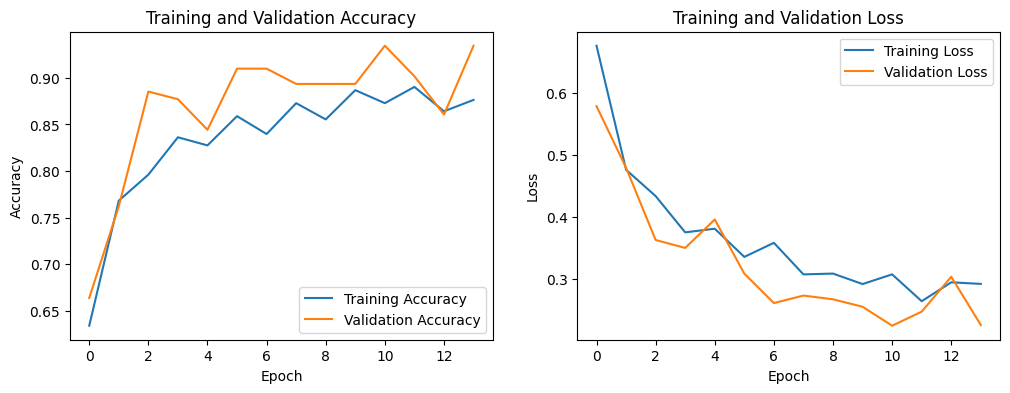

Training history plots generated.

Evaluating model on test set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step - accuracy: 0.9388 - loss: 0.1915
Test Loss: 0.1936
Test Accuracy: 0.9355

Making predictions on the test set...
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 2s/step

Classification Report:
              precision    recall  f1-score   support

      Cancer       0.94      0.94      0.94        62
    Negative       0.94      0.94      0.94        62

    accuracy                           0.94       124
   macro avg       0.94      0.94      0.94       124
weighted avg       0.94      0.94      0.94       124


Generating Confusion Matrix...


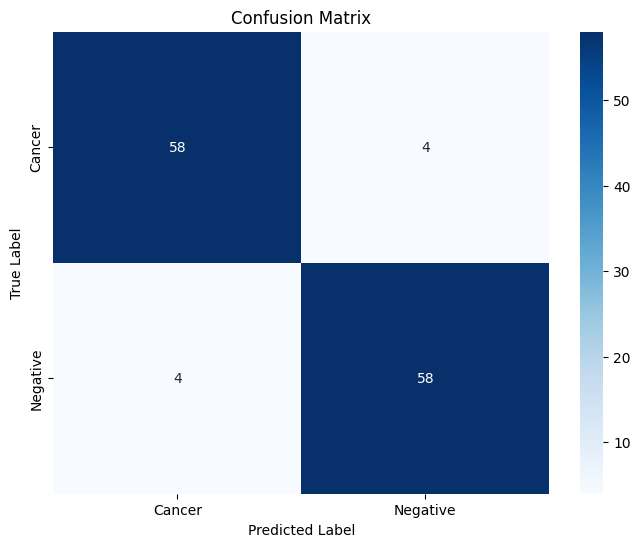

Model evaluation complete.


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

print("Evaluating model performance...")

# 2. Plot the training and validation accuracy and loss over epochs
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Adjust epochs_range to match the actual number of trained epochs
epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

print("Training history plots generated.")

# 3. Evaluate the trained model's performance on the test_generator
print("\nEvaluating model on test set...")
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 4. Predict the classes for the images in the test_generator
print("\nMaking predictions on the test set...")
predictions = model.predict(test_generator)

# Convert probabilities to binary class labels (0 or 1) using a threshold
predicted_labels = (predictions > 0.5).astype(int)

# Get true labels from the test_generator
true_labels = test_generator.classes

# 5. Generate and print a classification report
print("\nClassification Report:")
# Ensure class_names are sorted to match the generator's internal order
# test_generator.class_indices gives the mapping, e.g., {'Cancer': 0, 'Negative': 1}
# We need to ensure class_names is in this order for report labels
ordered_class_names = [name for name, index in sorted(test_generator.class_indices.items(), key=lambda item: item[1])]

print(classification_report(true_labels, predicted_labels, target_names=ordered_class_names))

# 6. Generate and plot a confusion matrix
print("\nGenerating Confusion Matrix...")
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=ordered_class_names, yticklabels=ordered_class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

print("Model evaluation complete.")

In [1]:
try:
    # Sauvegarde du modèle au format .h5 (Keras format)
    model.save("/content/model.h5")
    print("Modèle sauvegardé avec succès au format H5 à /content/model.h5")
    print("Vous pouvez télécharger ce fichier depuis l'explorateur de fichiers de Colab (icône de dossier à gauche).")
except NameError:
    print("Erreur : Le modèle 'model' n'est pas défini. Veuillez vous assurer que les cellules de définition et d'entraînement du modèle (cellules 'fe851d5a' et '3af590f2') ont été exécutées avant de tenter de sauvegarder le modèle.")
except Exception as e:
    print(f"Une erreur inattendue est survenue lors de la sauvegarde du modèle : {e}")

Erreur : Le modèle 'model' n'est pas défini. Veuillez vous assurer que les cellules de définition et d'entraînement du modèle (cellules 'fe851d5a' et '3af590f2') ont été exécutées avant de tenter de sauvegarder le modèle.
